In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, label_binarize
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, Callback
from itertools import cycle
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from collections import Counter
import shutil

In [9]:
# Paths
train_dir = r"C:\Users\guitar123\Desktop\Senior Project\dataset\HAM10000\train"
val_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\val"
test_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\test"

# Constants
IMAGE_HEIGHT = 600
IMAGE_WIDTH = 450
SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
IMAGE_CHANNELS = 3  # Assuming RGB images
BATCH_SIZE = 32
EPOCHS = 1000
NUM_CLASSES = len(os.listdir(train_dir))

In [3]:
# Resample function to balance each class to 500 samples
def resample_data(directory, target_count=500):
    class_dirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    for class_dir in class_dirs:
        class_path = os.path.join(directory, class_dir)
        images = glob(os.path.join(class_path, "*.jpg"))
        current_count = len(images)
        if current_count < target_count:
            # Augment the class to have `target_count` images
            for i in range(target_count - current_count):
                image = images[i % current_count]
                image_name = os.path.basename(image)
                new_image_name = f"aug_{i}_{image_name}"
                new_image_path = os.path.join(class_path, new_image_name)
                shutil.copy(image, new_image_path)
        elif current_count > target_count:
            # Reduce the class to `target_count` images
            for image in images[target_count:]:
                os.remove(image)
                
def resample_data1(directory, target_count=300):
    class_dirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    for class_dir in class_dirs:
        class_path = os.path.join(directory, class_dir)
        images = glob(os.path.join(class_path, "*.jpg"))
        current_count = len(images)
        if current_count < target_count:
            # Augment the class to have `target_count` images
            for i in range(target_count - current_count):
                image = images[i % current_count]
                image_name = os.path.basename(image)
                new_image_name = f"aug_{i}_{image_name}"
                new_image_path = os.path.join(class_path, new_image_name)
                shutil.copy(image, new_image_path)
        elif current_count > target_count:
            # Reduce the class to `target_count` images
            for image in images[target_count:]:
                os.remove(image)

In [10]:
## Resample training data
#resample_data(train_dir)
#resample_data1(val_dir)


# Create ImageDataGenerator instances
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 3500 images belonging to 7 classes.
Found 2005 images belonging to 7 classes.
Found 1515 images belonging to 7 classes.


In [11]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
import os

# Load the VGG16 model without the top fully connected layers (include_top=False)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))

# Freeze the base_model layers to prevent them from being trained
for layer in base_model.layers[-30:]:
    layer.trainable = False
    
## Unfreeze the top layers for fine-tuning
#for layer in base_model.layers[-30:]:
#    layer.trainable = True

# Add custom layers on top of the base model with L2 regularization
x = base_model.output
x = Dropout(0.3)(x)
x = GlobalAveragePooling2D()(x)

# Add Dense layers with L2 regularization
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.3)(x)
x = Flatten()(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.3)(x)
#x = Flatten()(x)
x = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.3)(x)
#x = Flatten()(x)
x = Dense(7, activation='softmax', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.3)(x)
#x = Flatten()(x)

# Final output layer
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Define the final model
model = Model(inputs=base_model.input, outputs=predictions)

from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['acc'])

# Summary of the model
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 600, 450, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 299, 224, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 299, 224, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                           

In [12]:
# Metrics callback for precision
class MetricsCallback(Callback):
    def __init__(self, val_generator):
        super(MetricsCallback, self).__init__()
        self.val_generator = val_generator

    def on_epoch_end(self, epoch, logs=None):
        y_true = self.val_generator.classes
        y_pred = self.model.predict(self.val_generator)
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Calculate precision only
        precision, _, _, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')

        val_loss = logs['val_loss']
        val_accuracy = logs.get('val_accuracy', logs.get('val_acc'))  # Handle different versions

        print(f'Epoch {epoch + 1} - '
              f'Validation Loss: {val_loss:.4f}, '
              f'Validation Accuracy: {val_accuracy:.4f}, '
              f'Validation Precision: {precision:.4f}')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# Metrics callback
metrics_callback = MetricsCallback(val_generator)

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the callback to save the best model
checkpoint = ModelCheckpoint(
    'inceptionv3.h5',       # Path to save the model
    monitor='val_loss',     # Metric to monitor ('val_loss' or 'val_accuracy')
    save_best_only=True,    # Save only the best model
    mode='min',             # Save model when the validation loss decreases ('min' for loss, 'max' for accuracy)
    verbose=1
)

# Train the model with ModelCheckpoint
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stopping, metrics_callback, checkpoint, reduce_lr],
    verbose=2
)


Epoch 1/1000
63/63 [==============================] - 17s 250ms/step
Epoch 1 - Validation Loss: 4.7955, Validation Accuracy: 0.1092, Validation Precision: 0.0157

Epoch 1: val_loss improved from inf to 4.79551, saving model to inceptionv3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


110/110 - 174s - loss: 5.2050 - acc: 0.1811 - val_loss: 4.7955 - val_acc: 0.1092 - lr: 1.0000e-04 - 174s/epoch - 2s/step
Epoch 2/1000
63/63 [==============================] - 16s 249ms/step
Epoch 2 - Validation Loss: 4.0647, Validation Accuracy: 0.2284, Validation Precision: 0.6957

Epoch 2: val_loss improved from 4.79551 to 4.06472, saving model to inceptionv3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


110/110 - 163s - loss: 4.2691 - acc: 0.2091 - val_loss: 4.0647 - val_acc: 0.2284 - lr: 1.0000e-04 - 163s/epoch - 1s/step
Epoch 3/1000
63/63 [==============================] - 14s 229ms/step
Epoch 3 - Validation Loss: 3.4596, Validation Accuracy: 0.4035, Validation Precision: 0.7463

Epoch 3: val_loss improved from 4.06472 to 3.45963, saving model to inceptionv3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


110/110 - 154s - loss: 3.6230 - acc: 0.2651 - val_loss: 3.4596 - val_acc: 0.4035 - lr: 1.0000e-04 - 154s/epoch - 1s/step
Epoch 4/1000
63/63 [==============================] - 14s 224ms/step
Epoch 4 - Validation Loss: 3.1203, Validation Accuracy: 0.4175, Validation Precision: 0.6900

Epoch 4: val_loss improved from 3.45963 to 3.12035, saving model to inceptionv3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


110/110 - 151s - loss: 3.1930 - acc: 0.2714 - val_loss: 3.1203 - val_acc: 0.4175 - lr: 1.0000e-04 - 151s/epoch - 1s/step
Epoch 5/1000
63/63 [==============================] - 14s 229ms/step
Epoch 5 - Validation Loss: 2.8720, Validation Accuracy: 0.4155, Validation Precision: 0.6941

Epoch 5: val_loss improved from 3.12035 to 2.87202, saving model to inceptionv3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


110/110 - 155s - loss: 2.9137 - acc: 0.2589 - val_loss: 2.8720 - val_acc: 0.4155 - lr: 1.0000e-04 - 155s/epoch - 1s/step
Epoch 6/1000
63/63 [==============================] - 16s 248ms/step
Epoch 6 - Validation Loss: 2.6101, Validation Accuracy: 0.4803, Validation Precision: 0.6774

Epoch 6: val_loss improved from 2.87202 to 2.61011, saving model to inceptionv3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


110/110 - 160s - loss: 2.6818 - acc: 0.3389 - val_loss: 2.6101 - val_acc: 0.4803 - lr: 1.0000e-04 - 160s/epoch - 1s/step
Epoch 7/1000
63/63 [==============================] - 15s 233ms/step
Epoch 7 - Validation Loss: 2.4466, Validation Accuracy: 0.5372, Validation Precision: 0.6756

Epoch 7: val_loss improved from 2.61011 to 2.44661, saving model to inceptionv3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


110/110 - 160s - loss: 2.5369 - acc: 0.3617 - val_loss: 2.4466 - val_acc: 0.5372 - lr: 1.0000e-04 - 160s/epoch - 1s/step
Epoch 8/1000
63/63 [==============================] - 15s 237ms/step
Epoch 8 - Validation Loss: 2.4395, Validation Accuracy: 0.4544, Validation Precision: 0.7105

Epoch 8: val_loss improved from 2.44661 to 2.43950, saving model to inceptionv3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


110/110 - 149s - loss: 2.4248 - acc: 0.3546 - val_loss: 2.4395 - val_acc: 0.4544 - lr: 1.0000e-04 - 149s/epoch - 1s/step
Epoch 9/1000
63/63 [==============================] - 15s 235ms/step
Epoch 9 - Validation Loss: 2.2821, Validation Accuracy: 0.5012, Validation Precision: 0.6968

Epoch 9: val_loss improved from 2.43950 to 2.28207, saving model to inceptionv3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


110/110 - 162s - loss: 2.3274 - acc: 0.3586 - val_loss: 2.2821 - val_acc: 0.5012 - lr: 1.0000e-04 - 162s/epoch - 1s/step
Epoch 10/1000
63/63 [==============================] - 15s 229ms/step
Epoch 10 - Validation Loss: 2.1730, Validation Accuracy: 0.5526, Validation Precision: 0.6836

Epoch 10: val_loss improved from 2.28207 to 2.17303, saving model to inceptionv3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


110/110 - 149s - loss: 2.2324 - acc: 0.3700 - val_loss: 2.1730 - val_acc: 0.5526 - lr: 1.0000e-04 - 149s/epoch - 1s/step
Epoch 11/1000
63/63 [==============================] - 15s 241ms/step
Epoch 11 - Validation Loss: 2.1941, Validation Accuracy: 0.4778, Validation Precision: 0.7103

Epoch 11: val_loss did not improve from 2.17303
110/110 - 157s - loss: 2.1591 - acc: 0.3806 - val_loss: 2.1941 - val_acc: 0.4778 - lr: 1.0000e-04 - 157s/epoch - 1s/step
Epoch 12/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 15s 238ms/step
Epoch 12 - Validation Loss: 2.0738, Validation Accuracy: 0.5421, Validation Precision: 0.6823

Epoch 12: val_loss improved from 2.17303 to 2.07384, saving model to inceptionv3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


110/110 - 162s - loss: 2.0888 - acc: 0.3877 - val_loss: 2.0738 - val_acc: 0.5421 - lr: 1.0000e-04 - 162s/epoch - 1s/step
Epoch 13/1000
63/63 [==============================] - 17s 275ms/step
Epoch 13 - Validation Loss: 1.9003, Validation Accuracy: 0.6933, Validation Precision: 0.6471

Epoch 13: val_loss improved from 2.07384 to 1.90034, saving model to inceptionv3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


110/110 - 169s - loss: 2.0558 - acc: 0.3731 - val_loss: 1.9003 - val_acc: 0.6933 - lr: 1.0000e-04 - 169s/epoch - 2s/step
Epoch 14/1000
63/63 [==============================] - 15s 235ms/step
Epoch 14 - Validation Loss: 1.9621, Validation Accuracy: 0.5796, Validation Precision: 0.6719

Epoch 14: val_loss did not improve from 1.90034
110/110 - 168s - loss: 2.0219 - acc: 0.3711 - val_loss: 1.9621 - val_acc: 0.5796 - lr: 1.0000e-04 - 168s/epoch - 2s/step
Epoch 15/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 15s 240ms/step
Epoch 15 - Validation Loss: 2.2339, Validation Accuracy: 0.2968, Validation Precision: 0.6954

Epoch 15: val_loss did not improve from 1.90034
110/110 - 155s - loss: 2.0030 - acc: 0.3591 - val_loss: 2.2339 - val_acc: 0.2968 - lr: 1.0000e-04 - 155s/epoch - 1s/step
Epoch 16/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 15s 232ms/step
Epoch 16 - Validation Loss: 1.8527, Validation Accuracy: 0.6145, Validation Precision: 0.6659

Epoch 16: val_loss improved from 1.90034 to 1.85272, saving model to inceptionv3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


110/110 - 165s - loss: 1.9758 - acc: 0.3669 - val_loss: 1.8527 - val_acc: 0.6145 - lr: 1.0000e-04 - 165s/epoch - 2s/step
Epoch 17/1000
63/63 [==============================] - 16s 261ms/step
Epoch 17 - Validation Loss: 1.9110, Validation Accuracy: 0.5392, Validation Precision: 0.6889

Epoch 17: val_loss did not improve from 1.85272
110/110 - 162s - loss: 1.9136 - acc: 0.3760 - val_loss: 1.9110 - val_acc: 0.5392 - lr: 1.0000e-04 - 162s/epoch - 1s/step
Epoch 18/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 225ms/step
Epoch 18 - Validation Loss: 1.9783, Validation Accuracy: 0.4579, Validation Precision: 0.6927

Epoch 18: val_loss did not improve from 1.85272
110/110 - 135s - loss: 1.8972 - acc: 0.3817 - val_loss: 1.9783 - val_acc: 0.4579 - lr: 1.0000e-04 - 135s/epoch - 1s/step
Epoch 19/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 225ms/step
Epoch 19 - Validation Loss: 1.9820, Validation Accuracy: 0.4160, Validation Precision: 0.7077

Epoch 19: val_loss did not improve from 1.85272
110/110 - 131s - loss: 1.8740 - acc: 0.3691 - val_loss: 1.9820 - val_acc: 0.4160 - lr: 1.0000e-04 - 131s/epoch - 1s/step
Epoch 20/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 226ms/step
Epoch 20 - Validation Loss: 1.9265, Validation Accuracy: 0.4559, Validation Precision: 0.6859

Epoch 20: val_loss did not improve from 1.85272
110/110 - 131s - loss: 1.8473 - acc: 0.3774 - val_loss: 1.9265 - val_acc: 0.4559 - lr: 1.0000e-04 - 131s/epoch - 1s/step
Epoch 21/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 225ms/step
Epoch 21 - Validation Loss: 1.8199, Validation Accuracy: 0.5222, Validation Precision: 0.6941

Epoch 21: val_loss improved from 1.85272 to 1.81988, saving model to inceptionv3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


110/110 - 132s - loss: 1.8183 - acc: 0.3994 - val_loss: 1.8199 - val_acc: 0.5222 - lr: 1.0000e-04 - 132s/epoch - 1s/step
Epoch 22/1000
63/63 [==============================] - 14s 225ms/step
Epoch 22 - Validation Loss: 1.7597, Validation Accuracy: 0.5771, Validation Precision: 0.7885

Epoch 22: val_loss improved from 1.81988 to 1.75975, saving model to inceptionv3.h5
110/110 - 132s - loss: 1.7938 - acc: 0.3929 - val_loss: 1.7597 - val_acc: 0.5771 - lr: 1.0000e-04 - 132s/epoch - 1s/step
Epoch 23/1000
63/63 [==============================] - 14s 225ms/step
Epoch 23 - Validation Loss: 1.8822, Validation Accuracy: 0.4499, Validation Precision: 0.6927

Epoch 23: val_loss did not improve from 1.75975
110/110 - 131s - loss: 1.7783 - acc: 0.3963 - val_loss: 1.8822 - val_acc: 0.4499 - lr: 1.0000e-04 - 131s/epoch - 1s/step
Epoch 24/1000
63/63 [==============================] - 14s 225ms/step
Epoch 24 - Validation Loss: 1.7764, Validation Accuracy: 0.5287, Validation Precision: 0.6964

Epoch 24: 

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


110/110 - 133s - loss: 1.7420 - acc: 0.3920 - val_loss: 1.7010 - val_acc: 0.5706 - lr: 1.0000e-04 - 133s/epoch - 1s/step
Epoch 27/1000
63/63 [==============================] - 14s 225ms/step
Epoch 27 - Validation Loss: 1.7597, Validation Accuracy: 0.5007, Validation Precision: 0.6874

Epoch 27: val_loss did not improve from 1.70103
110/110 - 132s - loss: 1.7173 - acc: 0.3994 - val_loss: 1.7597 - val_acc: 0.5007 - lr: 1.0000e-04 - 132s/epoch - 1s/step
Epoch 28/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 14s 225ms/step
Epoch 28 - Validation Loss: 1.6442, Validation Accuracy: 0.6015, Validation Precision: 0.6777

Epoch 28: val_loss improved from 1.70103 to 1.64419, saving model to inceptionv3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


110/110 - 133s - loss: 1.6763 - acc: 0.4151 - val_loss: 1.6442 - val_acc: 0.6015 - lr: 1.0000e-04 - 133s/epoch - 1s/step
Epoch 29/1000
63/63 [==============================] - 14s 225ms/step
Epoch 29 - Validation Loss: 1.5939, Validation Accuracy: 0.6279, Validation Precision: 0.7241

Epoch 29: val_loss improved from 1.64419 to 1.59390, saving model to inceptionv3.h5
110/110 - 134s - loss: 1.6618 - acc: 0.4123 - val_loss: 1.5939 - val_acc: 0.6279 - lr: 1.0000e-04 - 134s/epoch - 1s/step
Epoch 30/1000
63/63 [==============================] - 14s 225ms/step
Epoch 30 - Validation Loss: 1.6684, Validation Accuracy: 0.5576, Validation Precision: 0.6902

Epoch 30: val_loss did not improve from 1.59390
110/110 - 131s - loss: 1.6556 - acc: 0.4069 - val_loss: 1.6684 - val_acc: 0.5576 - lr: 1.0000e-04 - 131s/epoch - 1s/step
Epoch 31/1000
63/63 [==============================] - 14s 222ms/step
Epoch 31 - Validation Loss: 1.7148, Validation Accuracy: 0.5092, Validation Precision: 0.7243

Epoch 31: 

In [14]:
# Calculate precision, recall, and f1 score after training
y_true = val_generator.classes
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')

print(f'Final Precision: {precision:.4f}')
print(f'Final Recall: {recall:.4f}')
print(f'Final F1 Score: {f1_score:.4f}')

63/63 [==============================] - 14s 220ms/step
Final Precision: 0.7275
Final Recall: 0.6409
Final F1 Score: 0.6455


48/48 [==============================] - 11s 224ms/step - loss: 1.5014 - acc: 0.6106
Test accuracy: 0.6105610728263855


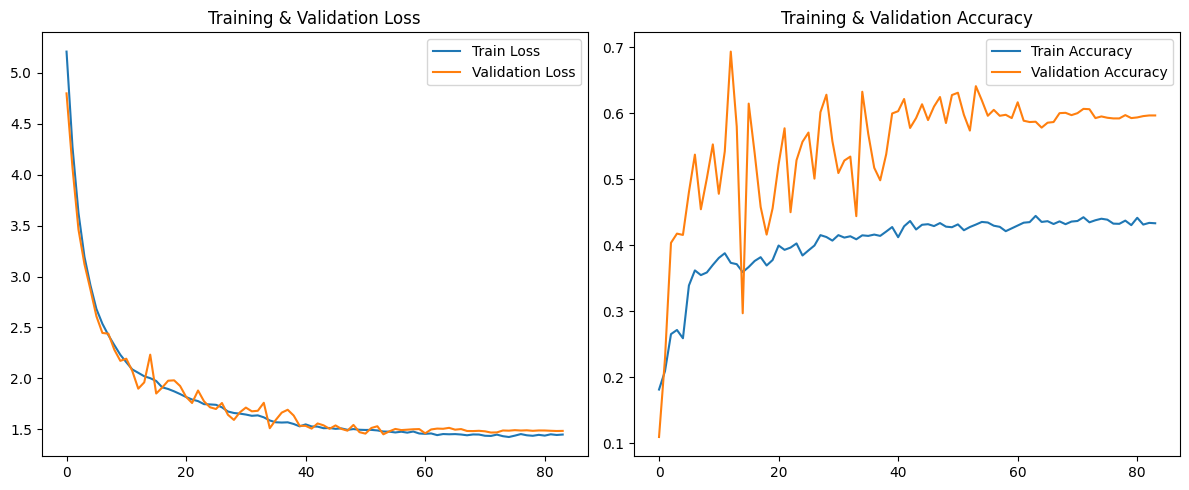

In [15]:
# Evaluate the model on the test set
test_score = model.evaluate(test_generator)
print('Test accuracy:', test_score[1])

# Plot the training and validation accuracy and loss at each epoch
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot Training & Validation Loss
axs[0].plot(history.history['loss'], label='Train Loss')
axs[0].plot(history.history['val_loss'], label='Validation Loss')
axs[0].legend()
axs[0].set_title('Training & Validation Loss')

# Plot Training & Validation Accuracy
axs[1].plot(history.history['acc'], label='Train Accuracy')
axs[1].plot(history.history['val_acc'], label='Validation Accuracy')
axs[1].legend()
axs[1].set_title('Training & Validation Accuracy')

plt.tight_layout()
plt.show()

110/110 [==============================] - 93s 845ms/step


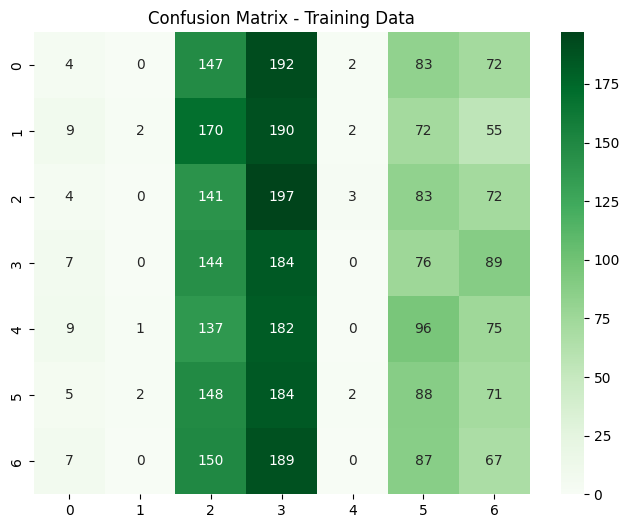

63/63 [==============================] - 14s 217ms/step


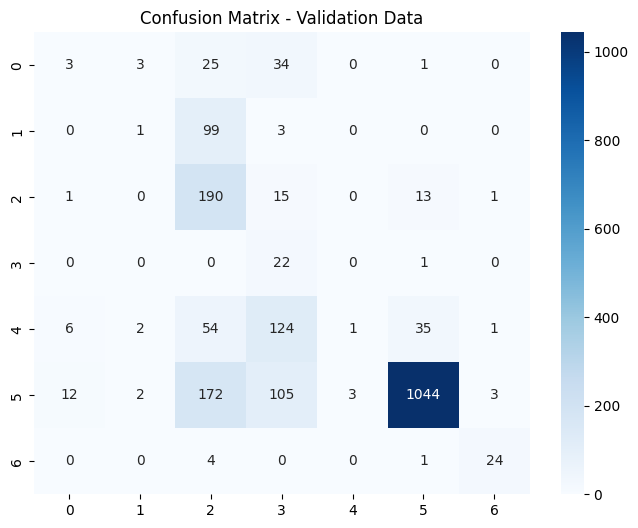

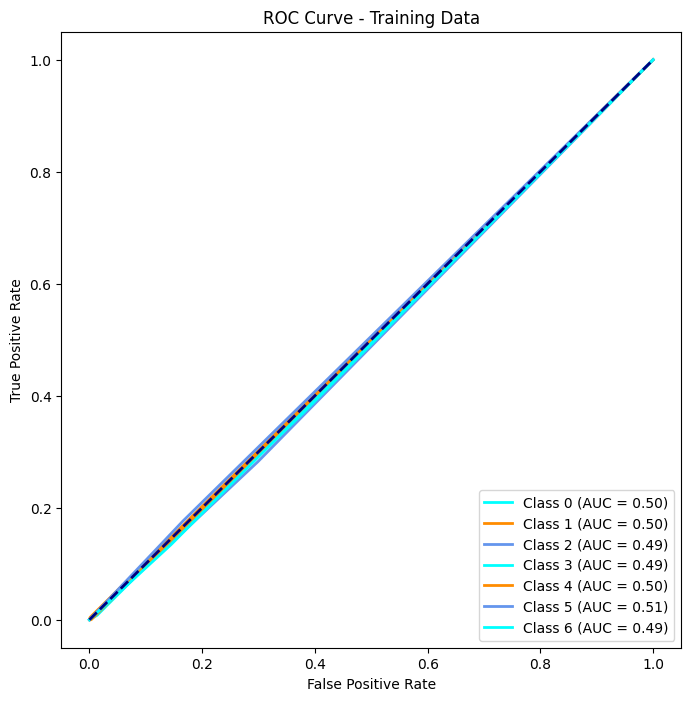

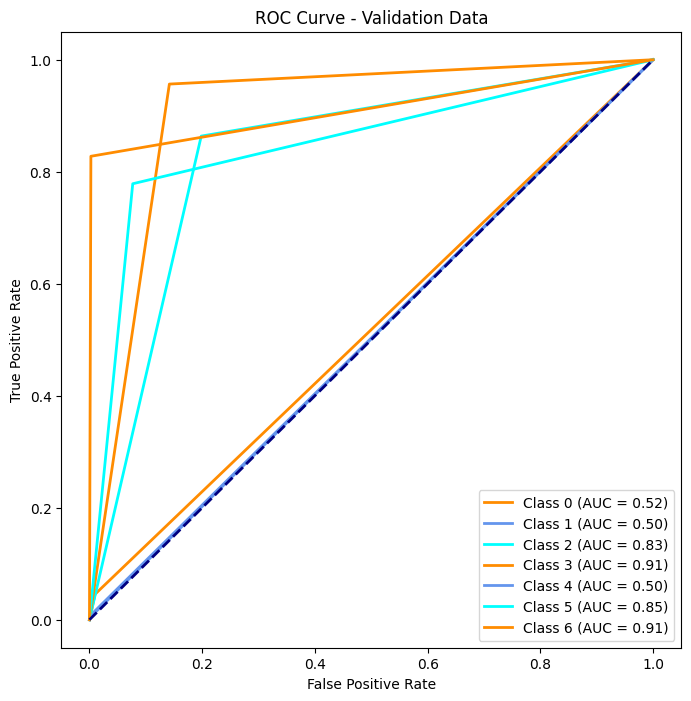

In [16]:
# Confusion matrix for training data
y_train_true = train_generator.classes
y_train_pred = model.predict(train_generator)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
cm_train = confusion_matrix(y_train_true, y_train_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Training Data')
plt.show()

# Confusion matrix for validation data
y_val_true = val_generator.classes
y_val_pred = model.predict(val_generator)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
cm_val = confusion_matrix(y_val_true, y_val_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Validation Data')
plt.show()

# AUC-ROC curve for training data
y_train_true_binary = label_binarize(y_train_true, classes=np.unique(y_train_true))
y_train_pred_binary = label_binarize(y_train_pred_classes, classes=np.unique(y_train_true))

fpr_train = dict()
tpr_train = dict()
roc_auc_train = dict()

for i in range(NUM_CLASSES):
    fpr_train[i], tpr_train[i], _ = roc_curve(y_train_true_binary[:, i], y_train_pred_binary[:, i])
    roc_auc_train[i] = roc_auc_score(y_train_true_binary[:, i], y_train_pred_binary[:, i])

plt.figure(figsize=(8, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])

for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr_train[i], tpr_train[i], color=color, lw=2, label=f'Class {i} (AUC = {roc_auc_train[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Training Data')
plt.legend(loc='lower right')
plt.show()

# AUC-ROC curve for validation data
y_val_true_binary = label_binarize(y_val_true, classes=np.unique(y_val_true))
y_val_pred_binary = label_binarize(y_val_pred_classes, classes=np.unique(y_val_true))

fpr_val = dict()
tpr_val = dict()
roc_auc_val = dict()

for i in range(NUM_CLASSES):
    fpr_val[i], tpr_val[i], _ = roc_curve(y_val_true_binary[:, i], y_val_pred_binary[:, i])
    roc_auc_val[i] = roc_auc_score(y_val_true_binary[:, i], y_val_pred_binary[:, i])

plt.figure(figsize=(8, 8))
for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr_val[i], tpr_val[i], color=color, lw=2, label=f'Class {i} (AUC = {roc_auc_val[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Validation Data')
plt.legend(loc='lower right')
plt.show()
